# Photometry Tutorial
In this notebook, we'll go over the basics of photometric analysis using python. We will mainly be using the `photutils` package. If you don't have this package installed, type at your command line:

```bash
pip install photutils
```
Make sure the version of `pip` you use is for Python 3.xx! This package contains a number of very useful funtions for doing photometric analysis, I encourage you to become familiar with the [documentation](https://photutils.readthedocs.io/en/stable/index.html).

## 0. The Basics
The idea of photometry is to identify sources in the image data and determine their flux. There are several techniques for doing this, but I will focus on two of them in this notebook: PSF fitting and aperture photometry.

* __PSF fitting__ involves determining the point spread function of a point source by fitting a 2D Gaussian to the data (or perhaps a modified 2D Gaussian, such as elliptical). This fitted PSF is then integrated to estimate the total intensity of the source.
* __Aperture photometry__ is a somewhat simpler technique that makes no actual assumption about the shape of the PSF and involves simply summing up the counts within an aperture centered on the source.

The first thing we'll need to do before we can do any photometry, though, is figure out where the sources in our image are.

In [76]:
import photutils
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.colors import LogNorm

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#norm = ImageNormalize(stretch=SqrtStretch())
norm = LogNorm()

In [49]:
projectdir = '/Users/sjhamilton/Google Drive/Graduate School/2016:2017/GSI_Astro461/PythonCookbook/SampleData/photometry/'
sciencedir = projectdir+'science/'

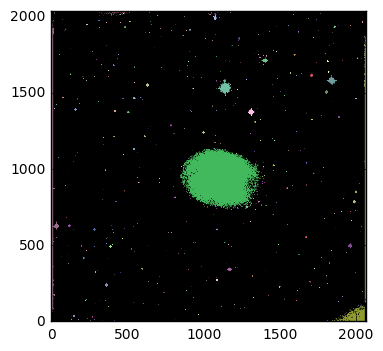

In [99]:
data = fits.getdata(sciencedir+'calibrated.fits')[0]
threshold = photutils.detect_threshold(data, snr=3.)
#bkg = photutils.Background2D(data, (50,50), filter_size=(5,5))

from photutils.utils import random_cmap
rand_cmap = random_cmap(segm.max + 1, random_state=12345)
segm = photutils.detect_sources(data, threshold, npixels=5)
plt.imshow(segm, origin='lower', cmap=rand_cmap)

In [105]:
props = photutils.source_properties(data-bkg.background, segm)
columns = ['id','xcentroid','ycentroid','area','source_sum']
tbl = photutils.properties_table(props, columns=columns)
tbl.sort('area')
print(tbl)

 id    xcentroid     ycentroid     area     source_sum 
          pix           pix        pix2                
---- ------------- ------------- -------- -------------
 376  1328.1927262 827.319809185      4.0  110.93227212
1020 761.584113546 2029.97541845      5.0 314.822004076
 606 143.892831016 1296.20602062      5.0 4670.81841929
 321 1176.93210033 753.250638703      5.0 31.0515329746
 916 1048.72160287 2006.44467922      5.0 299.499742514
 915 496.844130595 2005.78816569      5.0 374.922009243
 314  1091.9776079  746.96839384      5.0  140.67251684
 914 486.550792891 2006.80321087      5.0 343.894184234
 312 1192.32999529 746.262410115      5.0 72.8525050664
 912 1094.25437344 2005.16805996      5.0 317.789612925
 ...           ...           ...      ...           ...
 198 1953.04739471 491.081366075    525.0  2188480.1002
 743 1398.22281596 1701.82224551    690.0 2326266.96382
 619 1307.68857252 1364.84325595   1089.0 3222706.15408
 683 1833.69675754 1569.32724008   1806.0 461257

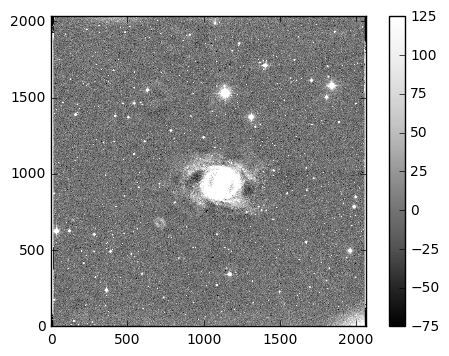

In [94]:
plt.imshow(data - bkg.background, origin='lower', cmap='Greys_r', vmin=-75, vmax=125)
plt.colorbar()
#x = plt.hist((data-bkg.background).flatten(), bins=1000, range=[-200,200])
fits.writeto('test.fits', data=(data-bkg.background))

## 1. Photometry via PSF Fitting

This first tutorial will introduce you to doing photometry using the PSF fitting functions within `photutils`.

## 2. Photometry via Apertures

This second tutorial will teach you how to use the functions and tools within `photutils.apertures` to perform photometry.

## TESTING WITH PHOTUTILS DOCS

In [44]:
from astropy.stats import sigma_clipped_stats

data = fits.getdata(sciencedir+'calibrated.fits')[0]
mean, median, std = sigma_clipped_stats(data, sigma=3.0, iters=5)

daofind = photutils.DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(np.subtract(data, median))

iraffind = photutils.IRAFStarFinder(fwhm=3.0, threshold=5.*std)
sources2 = iraffind(np.subtract(data,median))

In [47]:
print(len(sources))
print(len(sources2))

1317
577


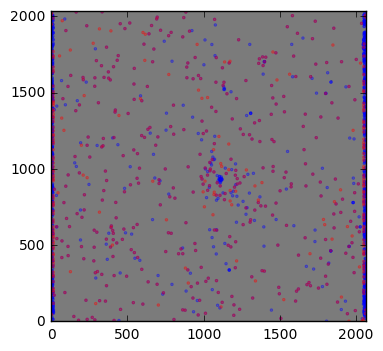

In [46]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = photutils.CircularAperture(positions, r=4.)
positions2 = (sources2['xcentroid'], sources2['ycentroid'])
apertures2 = photutils.CircularAperture(positions2, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='blue', lw=1.5, alpha=0.5)
apertures2.plot(color='red',lw=1.5, alpha=0.5)

In [42]:
thresh = median + 15*std
tbl = photutils.find_peaks(data, thresh, box_size=10)

(0, 2031)

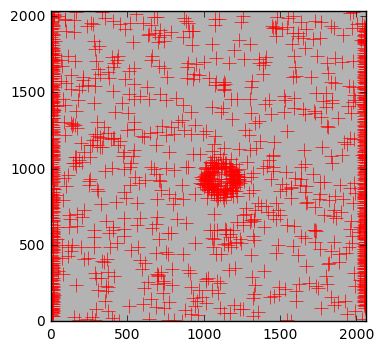

In [43]:
plt.imshow(data, cmap='Greys_r', origin='lower', norm=norm)
plt.plot(tbl['x_peak'], tbl['y_peak'], ls='none', color='red',
         marker='+', ms=10, lw=1.5)
plt.xlim(0, data.shape[1]-1)
plt.ylim(0, data.shape[0]-1)

In [8]:
%matplotlib inline

from photutils.datasets import make_100gaussians_image
#data = make_100gaussians_image()
data = fits.getdata(sciencedir+'calibrated.fits')

from photutils import detect_threshold
threshold = detect_threshold(data, snr=3.)

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
sigma = 2.0 * gaussian_fwhm_to_sigma    # FWHM = 2.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data, threshold, npixels=5)#, filter_kernel=kernel)

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.utils import random_cmap
rand_cmap = random_cmap(segm.max + 1, random_state=12345)
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax2.imshow(segm, origin='lower', cmap=rand_cmap)

RuntimeError: structure and input must have equal rank

In [ ]:
from photutils import deblend_sources
segm_deblend = deblend_sources(data, segm, npixels=5,
                               filter_kernel=kernel)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax2.imshow(segm_deblend, origin='lower', cmap=rand_cmap)